error in estimating w: [ 1.999583  -3.4009335]
error in estimating b: [4.2]


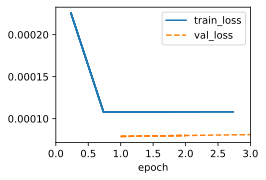

In [6]:
%matplotlib inline
from mxnet import autograd, np, npx
from d2l import mxnet as d2l

npx.set_np()

class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, alpha, rho, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = np.random.normal(0, sigma, (num_inputs, 1))
        self.b = np.zeros(1)
        self.w.attach_grad()
        self.b.attach_grad()

@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return np.dot(X, self.w) + self.b

@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):    
    # This is the L1 loss
    # l_1 = np.abs(y_hat - y)

    # This is the L2 loss
    # l_2 = (y_hat - y) ** 2 / 2

    # The Ridge regression loss
    # l = self.alpha * np.square(self.w).sum() + l_2

    # The Lasso regression loss
    # l= self.alpha * np.abs(self.w).sum() + l_1

    # The Elastic Net loss
    l1_loss = self.alpha *self.rho * np.abs(self.w).sum()
    l2_loss = self.alpha * (1 - self.rho) * np.square(self.w).sum() /2
    l = l1_loss + l2_loss 

    return l.mean()


class SGD(d2l.HyperParameters):  #@save
    # """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self, _):
        for param in self.params:
            param -= self.lr * param.grad

@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    for batch in self.train_dataloader:
        with autograd.record():
            loss = self.model.training_step(self.prepare_batch(batch))
        loss.backward()
        if self.gradient_clip_val > 0:
            self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step(1)
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

# model = LinearRegressionScratch(2, lr=0.03)
# model = LinearRegressionScratch(2, lr=0.03, alpha=0.1)
model = LinearRegressionScratch(2, lr=0.03, alpha=0.1, rho=06)
data = d2l.SyntheticRegressionData(w=np.array([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')